# 💻 Reklassifisering av data

Reklassifisering av data basert på spesifikke kriterier er en vanlig oppgave når man utfører GIS
analyse. Formålet med denne leksjonen er å se hvordan vi kan reklassifisere verdier
basert på noen kriterier. Vi kunne for eksempel klassifisere informasjon basert på
reisetider og boligpriser ved hjelp av disse kriteriene:


1. Hvis reisetiden til jobben min er mindre enn 30 minutter, **OG**
2. husleien for leiligheten er mindre enn 1000 € per måned

Hvis begge kriteriene er oppfylt: Jeg går for å se leiligheten og prøver å leie den
Hvis ikke: Jeg fortsetter å lete etter noe annet


I denne opplæringen vil vi:

1. Bruk klassifiseringsskjemaer fra PySAL [mapclassify
   bibliotek](https://pysal.org/mapclassify/) for å klassifisere befolkningstall til
   flere klasser.

2. Opprett en egendefinert klassifisering for å klassifisere reisetider og avstander for å finne ut gode steder å kjøpe en leilighet med disse forholdene:
   - god offentlig transport tilgjengelighet til sentrum
   - litt lenger borte fra sentrum hvor prisene antageligvis er lavere


## Inngangsdata

Vi vil bruke befolkningsdata fra [SSB](https://kart.ssb.no/) for Oslo, som inneholder 2380 celler for Oslo kommune.

In [8]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

In [13]:
import geopandas

rutenett = geopandas.read_file(DATA_MAPPE / "ssb_rutenett" / "befolkning_250m_2023_oslo.gpkg")

rutenett.head()

,ru250m,pop_tot,geometry
0,22637506643000,14,"MULTIPOLYGON (((264000.000 6643000.000, 263750..."
1,22640006643000,177,"MULTIPOLYGON (((264250.000 6643000.000, 264000..."
2,22642506643000,169,"MULTIPOLYGON (((264500.000 6643000.000, 264250..."
3,22645006643000,261,"MULTIPOLYGON (((264750.000 6643000.000, 264500..."
4,22647506643000,106,"MULTIPOLYGON (((265000.000 6643000.000, 264750..."


## Vanlige klassifiseringer

### Klassifiseringsskjemaer for tematiske kart

[PySAL](https://pysal.org/) -modulen er et omfattende Python-bibliotek for romlig
analyse. Det inkluderer også alle de vanligste dataklassifiseringene som er
brukt vanlig f.eks. når man visualiserer data. Tilgjengelige kartklassifiseringer i [pysal's
mapclassify -modul](https://github.com/pysal/mapclassify):

- Box Plot
- Equal Interval
- Fisher Jenks
- Fisher Jenks Sampled
- HeadTail Breaks
- Jenks Caspall
- Jenks Caspall Forced
- Jenks Caspall Sampled
- Max P Classifier
- Maximum Breaks
- Natural Breaks
- Quantiles
- Percentiles
- Std Mean
- User Defined


Det er mange forskjellige variabler i tilgjengelighets datasettet (se
[herfra beskrivelsen](http://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix-2015)
for alle attributter) men det vi er interessert i er kolonner kalt `pt_r_tt`
som forteller tiden i minutter det tar å nå bysentrum fra
forskjellige deler av byen, og `walk_d` som forteller nettverksavstanden ved
veier for å nå bysentrum fra forskjellige deler av byen (nesten lik
Euklidsk avstand).

**NoData-verdiene presenteres med verdi -1**. 
Derfor må vi først fjerne No Data-verdiene.

In [14]:
# Inkluder bare data som er over eller lik 0
rutenett = rutenett.loc[rutenett["pop_tot"] >=0]

La oss plotte dataene og se hvordan det ser ut
- `cmap` parameter definerer fargekartet. Les mer om [valg av fargekart i matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
- `scheme` alternativ skalerer fargene i henhold til et klassifiseringsskjema (krever at `mapclassify` modulen er installert):

<Axes: >

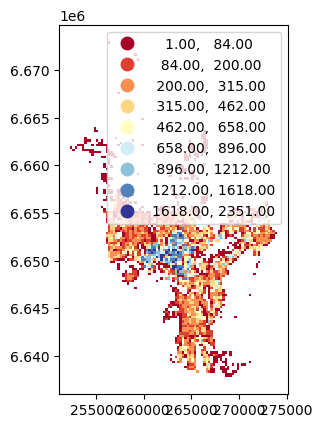

In [15]:
# Plott ved hjelp av 9 klasser og klassifiser verdiene ved hjelp av "Natural Breaks" klassifisering
rutenett.plot(column="pop_tot", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True, aspect=1)

Som vi kan se fra dette kartet, er reisetidene lavere i sør hvor
bysentrum ligger, men det er også noen områder med "god" tilgjengelighet også i
noen andre områder (hvor fargen er rød).

La oss også lage et plott om gangavstander:

<Axes: >

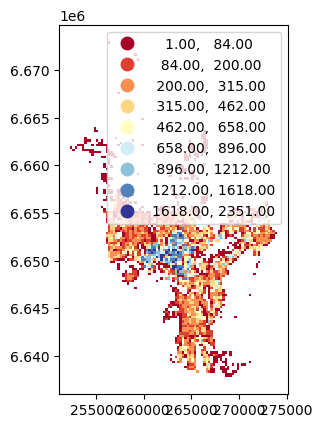

In [17]:
# Plott gangavstand
rutenett.plot(column="pop_tot", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

Ok, herfra kan vi se at gangavstandene (langs vei nettverket)
minner mer eller mindre om Euklidske avstander.

### Bruk av klassifiseringer på data

Som nevnt, definerer `scheme` alternativet klassifiseringsskjemaet ved hjelp av
`pysal/mapclassify`. La oss se nærmere på hvordan disse klassifiseringene fungerer.

In [18]:
import mapclassify

#### Natural Breaks

In [19]:
mapclassify.NaturalBreaks(y=rutenett["pop_tot"], k=9)

NaturalBreaks             

     Interval        Count
--------------------------
[   1.00,   84.00] |   680
(  84.00,  200.00] |   461
( 200.00,  315.00] |   512
( 315.00,  462.00] |   284
( 462.00,  658.00] |   181
( 658.00,  896.00] |    98
( 896.00, 1212.00] |    81
(1212.00, 1618.00] |    58
(1618.00, 2351.00] |    25

#### Quantiles (standard er 5 klasser):

In [20]:
mapclassify.Quantiles(y=rutenett["pop_tot"])

Quantiles                 

     Interval        Count
--------------------------
[   1.00,   31.00] |   480
(  31.00,  160.00] |   476
( 160.00,  262.00] |   476
( 262.00,  433.20] |   472
( 433.20, 2351.00] |   476

#### Trekk ut terskelverdiene

Det er mulig å trekke ut terskelverdiene i en matrise:

In [21]:
klassifiserer = mapclassify.NaturalBreaks(y=rutenett["pop_tot"], k=9)
klassifiserer.bins

array([  85.,  202.,  319.,  470.,  658.,  896., 1212., 1618., 2351.])

La oss bruke en av `Pysal` klassifiseringene på dataene våre og klassifisere
reisetider med offentlig transport til 9 klasser
Klassifiseringen må først initialiseres med `make()` funksjonen som tar
antall ønskede klasser som inngangsparameter

In [22]:
# Lag en Natural Breaks klassifisering
klassifiserer = mapclassify.NaturalBreaks.make(k=9)

- Nå kan vi bruke klassifiseringen på dataene våre ved å bruke `apply` -funksjonen

In [23]:
# Klassifiser dataene
klassifiseringer = rutenett[["pop_tot"]].apply(klassifiserer)

# La oss se hva vi har
klassifiseringer.head()

,pop_tot
0,0
1,1
2,1
3,2
4,1


In [24]:
type(klassifiseringer)

pandas.core.frame.DataFrame

Ok, så nå har vi en DataFrame der inngangskolonnen vår ble klassifisert til 9
forskjellige klasser (tallene 1-9) basert på [Natural Breaks
klassifisering](http://wiki-1-1930356585.us-east-1.elb.amazonaws.com/wiki/index.php/Jenks_Natural_Breaks_Classification).

Vi kan også legge til klassifiseringsverdiene direkte i en ny kolonne i vår dataframe:

In [25]:
# Gi nytt navn til kolonnen så vi vet at den ble klassifisert med naturlige brudd
rutenett["nb_pop_tot"] = rutenett[["pop_tot"]].apply(klassifiserer)

# Sjekk de opprinnelige verdiene og klassifiseringen
rutenett[["pop_tot", "nb_pop_tot"]].head()

,pop_tot,nb_pop_tot
0,14,0
1,177,1
2,169,1
3,261,2
4,106,1


Flott, nå har vi disse verdiene i vår tilgjengelighet GeoDataFrame. La oss
visualisere resultatene og se hvordan de ser ut.

<Axes: >

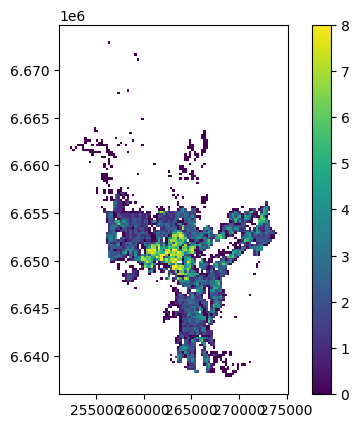

In [26]:
# Plott
rutenett.plot(column="nb_pop_tot", linewidth=0, legend=True)

Og her går vi, nå har vi et kart der vi har brukt en av de vanlige
klassifiseringene for å klassifisere dataene våre i 9 klasser.


## Plott et histogram

Et histogram er en grafisk representasjon av datafordelingen. Når
man klassifiserer data, er det alltid bra å vurdere hvordan dataene er fordelt,
og hvordan klassifiseringsskjemaet deler verdier i forskjellige områder.

- plott histogrammet ved hjelp av [pandas.DataFrame.plot.hist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.hist.html)
- Antall histogrambinner (grupper av data) kan kontrolleres ved hjelp av parameteren `bins`:

<Axes: ylabel='Frequency'>

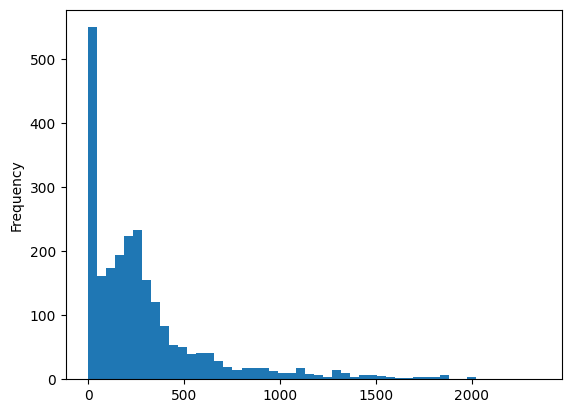

In [27]:
# Histogram for offentlig transport i rushtiden reisetid
rutenett["pop_tot"].plot.hist(bins=50)

La oss også legge til terskelverdier på toppen av histogrammet som vertikale linjer.

- Natural Breaks:

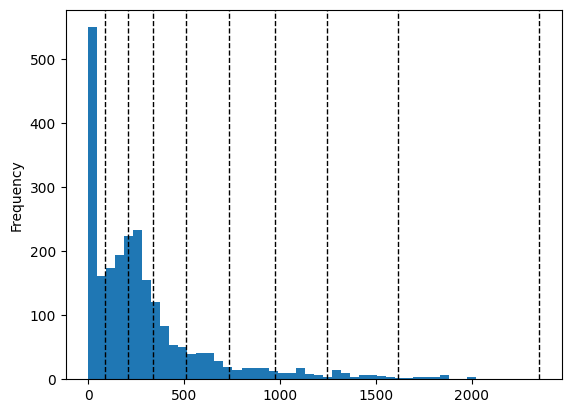

In [28]:
import matplotlib.pyplot as plt

# Definer klassifiserer
klassifiserer = mapclassify.NaturalBreaks(y=rutenett["pop_tot"], k=9)

# Plott histogram for offentlig transport i rushtiden reisetid
rutenett["pop_tot"].plot.hist(bins=50)

# Legg til vertikale linjer for klassebrudd
for break_point in klassifiserer.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

- Kvartiler:

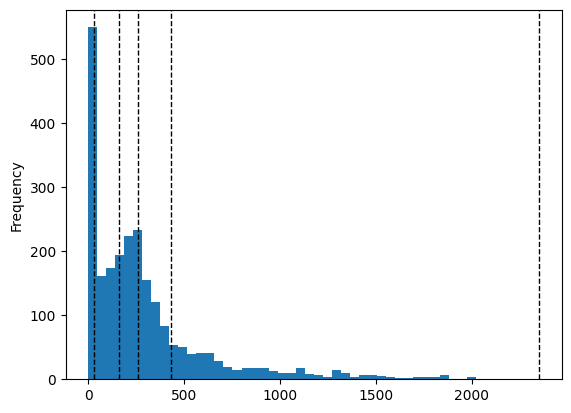

In [29]:
# Definer klassifiserer
klassifiserer = mapclassify.Quantiles(y=rutenett['pop_tot'])

# Plott histogram for offentlig transport i rushtiden reisetid
rutenett["pop_tot"].plot.hist(bins=50)

for break_point in klassifiserer.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

:::{admonition} Sjekk din forståelse
:class: tip

Velg en annen kolonne fra dataene (for eksempel reisetider med bil:
`car_r_t`). Gjør følgende visualiseringer ved hjelp av en av klassifiseringene
ordninger tilgjengelig fra
[pysal/mapclassify](https://github.com/pysal/mapclassify):
    
- histogram med vertikale linjer som viser klassifiseringens binger
- tematisk kart ved hjelp av klassifiseringsskjemaet
:::


## Bruke en egendefinert klassifisering

### Multikriterium dataklassifisering

La oss klassifisere geometriene i to klasser basert
på en gitt `terskel` -parameter. Hvis området til en polygon er lavere enn terskelverdien (f.eks., en viss avstand), vil utgangskolonnen få en verdi
0, hvis den er større, vil den få en verdi 1. Denne typen klassifisering kalles ofte en [binær
klassifisering](https://en.wikipedia.org/wiki/Binary_classification).

For å klassifisere hver rad i vår GeoDataFrame kan vi iterere over hver rad, eller vi kan bruke
en funksjon for hver rad. I vårt tilfelle vil vi bruke en [lambda funksjon](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-1/exercise-1.html#apply-ing-an-anonymous-lambda-function) for hver rad i
vår GeoDataFrame, som returnerer en verdi basert på de vilkårene vi gir.

La oss klassifisere basert på to kriterier: og finne ut rutenettceller

1. Rutenettceller der reisetiden er **lavere eller lik 20 minutter** 

2. *og* de er lenger unna **enn 4 km (4000 meter)** fra bysentrum.

La oss først se hvordan vi klassifiserer en enkelt rad:

In [ ]:
tilgjengelighet_rutenett.iloc[0]["pt_r_tt"] < 20 and tilgjengelighet_rutenett.iloc[0]["walk_d"] > 4000

In [ ]:
int(tilgjengelighet_rutenett.iloc[11293]["pt_r_tt"] < 20 and tilgjengelighet_rutenett.iloc[11293]["walk_d"] > 4000)

La oss nå bruke dette på vår GeoDataFrame og lagre det i en kolonne kalt `"suitable_area"`:

In [ ]:
tilgjengelighet_rutenett["suitable_area"] = tilgjengelighet_rutenett.apply(lambda row: int(row["pt_r_tt"] < 20 and row["walk_d"] > 4000), axis=1)

In [ ]:
tilgjengelighet_rutenett.head()

Ok, vi har nye verdier i `suitable_area` -kolonnen.

- Hvor mange polygoner passer for oss? La oss finne ut ved hjelp av en Pandas
  funksjon kalt `value_counts()` som returnerer antall forskjellige verdier i
  vår kolonne.

In [ ]:
# Få antall verdier
tilgjengelighet_rutenett["suitable_area"].value_counts()

Ok, så det ser ut til å være ni passende steder for oss hvor vi kan prøve å
finne en leilighet å kjøpe.

- La oss se hvor de er lokalisert:

In [ ]:
# Plott
tilgjengelighet_rutenett.plot(column="suitable_area", linewidth=0)

A-haa, ok så vi kan se at passende steder for oss med våre kriterier ser ut til
å være lokalisert i den østlige delen av bysentrum. Faktisk er de aktuelle stedene
langs metro linjen som gjør dem til gode steder i form av reisetid
til bysentrum siden metro er en veldig rask reisemåte.